In [0]:
# Run this only once whenever the notebook is opened and no drive is mounted
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# Run this if there is no gym-bubble-trouble repository
!cd drive/My\ Drive/ && git clone https://github.com/ferasboulala/gym-bubble-trouble.git

In [1]:
# Updating the repository and reinstalling the module
!cd drive/My\ Drive/gym-bubble-trouble && git pull origin master && pip install -e .
%cd drive/My\ Drive/gym-bubble-trouble

import sys
sys.path.append('bubbletrouble')
sys.path.append('gym_bubbletrouble/envs')

!mkdir -p ../models

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/ferasboulala/gym-bubble-trouble
 * branch            master     -> FETCH_HEAD
   dd70747..b0345ed  master     -> origin/master
Updating dd70747..b0345ed
Fast-forward
 gym_bubbletrouble/envs/bubbletrouble_env.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)
Obtaining file:///content/drive/My%20Drive/gym-bubble-trouble
  Found existing installation: gym-bubbletrouble 0.0.1
    Can't uninstall 'gym-bubbletrouble'. No files were found to uninstall.
  Running setup.py develop for gym-bubbletrouble
/content/drive/My Drive/gym-bubble-trouble


pygame 1.9.5
Hello from the pygame community. https://www.pygame.org/contribute.html


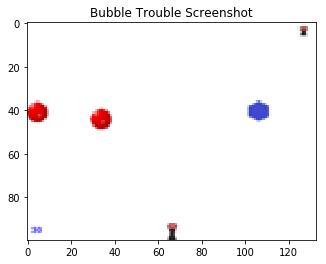

In [2]:
# OpenAI's gym
import gym
import gym.spaces

# BubbleTrouble environment
from bubbletrouble_env import BubbleTroubleEnv

# std
import math
import random
import glob

# 3rd party
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import numpy as np
from IPython.display import clear_output
import cv2

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQCNN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))
      
class DQN(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 2 * n_inputs)
        self.fc2 = nn.Linear(2 * n_inputs, 2 * n_inputs)
        self.fc3 = nn.Linear(2 * n_inputs, 2 * n_inputs)
        self.fc4 = nn.Linear(2 * n_inputs, 2 * n_inputs)
        self.fc5 = nn.Linear(2 * n_inputs, n_outputs)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return F.log_softmax(self.fc5(x), dim=1)


resize = T.Compose([T.ToPILImage(),
                    T.Resize(100, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_screen():
    screen = env.render(mode='rgb_array')
    return resize(screen).unsqueeze(0).to(device)

def convert_state(state):
    return torch.Tensor(state).unsqueeze(0).to(device)
  
    
# The following line does not work in colab
# env = gym.make('gym_bubbletrouble:BubbleTrouble-v0')

reward_dict = {'moving': 0, 'fire': 0, 'score': 1, 'death': -1, 'win': 0, 'step': 0}
K = 5
training_cnn = False

env = BubbleTroubleEnv(rewards=reward_dict, K=K, rand=True, timed=True)
env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Bubble Trouble Screenshot')
plt.show()

In [0]:
     
def plot_durations(episode_durations):
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Episode durations')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
        
def plot_losses(losses):
    plt.figure(2)
    plt.clf()
    losses_t = torch.tensor(losses, dtype=torch.float)
    plt.title('Training losses')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.plot(durations_t.numpy())
    if len(losses_t) >= 100:
        means = losses_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
        
        
def select_action(state, model, infer=False):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold or infer:
        with torch.no_grad(): # don't need intermediate results
            return model(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = None
    non_final_next_states = None

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch.type(torch.float)

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    return loss

In [0]:
BATCH_SIZE = 256
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 30
TARGET_UPDATE = 10
CHECKPOINT = 50

MODEL_FN = '../models/bubble-trouble-dqn-cnn'
steps_done = 0

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

n_actions = env.action_space.n

policy_net = None
target_net = None

if training_cnn:
    policy_net = DQCNN(screen_height, screen_width, n_actions).to(device)
    target_net = DQCNN(screen_height, screen_width, n_actions).to(device)
else:
    n_inputs = K * 5 + 3
    policy_net = DQN(n_inputs, n_actions).to(device)
    target_net = DQN(n_inputs, n_actions).to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(50000)

In [0]:
def compute_destroyed_balls(reward, steps):
    n = (reward - steps * reward_dict['step'] - 
            reward_dict['death']) // reward_dict['score']
    if n < 0:
        return 0
    return int(n)

episode_durations = []
losses = []
num_episodes = 10000

for i_episode in range(num_episodes):
    env.reset()
    
    state = None
    next_state = None
    last_state = None
    
    current_screen = None
    last_screen = None
    
    if training_cnn:
        # Black image
        last_screen = get_screen()
        current_screen = get_screen()
        state = current_screen - last_screen
    else:
        # Updating once with an idle action to get the first state
        state, _, _, _ = env.step(3)
        state = convert_state(state)
        last_state = state
        
    cum_reward = 0
    cum_loss = 0
    for t in count():
        action = select_action(state, policy_net)
        
        state, r, done, _ = env.step(action.item())
        state = convert_state(state)
        reward = torch.tensor([r], device=device)
        cum_reward += r

        if training_cnn:
            last_screen = current_screen
            current_screen = get_screen()
            
            if not done:
                next_state = current_screen - last_screen
            else:
                next_state = None
            memory.push(state, action, next_state, reward)
            state = next_state
        else:
            if done:
                state = None
            memory.push(last_state, action, state, reward)
            last_state = state

        cum_loss += optimize_model()
        
        if done:
            episode_durations.append(t + 1)
            losses.append(cum_loss / (t + 1))
            clear_output(wait=True)
            print(
                'Episode {}: Destroyed {} times in {} steps with {} loss'
                .format(i_episode + 1, 
                compute_destroyed_balls(cum_reward, t + 1), t + 1, 
                cum_loss / (t + 1))
            )
            break
            
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())  
        
    if i_episode % CHECKPOINT == 0:
        torch.save(policy_net, MODEL_FN)

torch.save(policy_net, MODEL_FN)
print('Complete')
plot_durations()
plot_losses()
env.close()
plt.ioff()
plt.show()

Episode 3410: Destroyed 17 times in 1349 steps


In [17]:
# Testing the policy with a random game. Can be called without training.
model = torch.load(MODEL_FN)
env.reset()

last_screen = get_screen()
current_screen = get_screen()
state = current_screen - last_screen
if not training_cnn:
    state, _, _, _ = env.step(3)
    state = convert_state(state)
img_array = []
delta_array = []
cum_reward = 0
for i in range(1000):
    img_array.append(env.render()) # Taking the high res image.
    
    action = select_action(state, model=model, infer=True)
    state, r, done, _ = env.step(action.item())
    state = convert_state(state)
    cum_reward += r
    
    last_screen = current_screen
    current_screen = get_screen()

    if training_cnn:
        state = current_screen - last_screen
    if done:
        break

print('Finished with {} balls destroyed'.format(compute_destroyed_balls(cum_reward, i)))
      
# Call this only when you are sure you won't be using the model anymore.
# There is a pygame bug with fonts where if you quit, it will not restart.
### env.close()

Finished with 12 balls destroyed


In [0]:
# Savingt the playback
out = cv2.VideoWriter(
    '../models/dqn-result.mp4',
    cv2.VideoWriter_fourcc(*'DIVX'), 
    30, 
    (640, 480)
)

for img in img_array:
    img_norm = cv2.cvtColor(np.uint8(img), cv2.COLOR_BGR2RGB)
    out.write(img_norm)
out.release()

# Discussion
1. Adding an idle state
2. Fitness function engineering
3. State transition engineering
4. CNN vs MLP